#Mushroom Classification Using K-mean Clustering
Xingsheng Wei

The purpose of this project is for me to learn and practice k-mean clustering, and see how it deal with catogorized data by using one-hot encoding, so the learning algorithm is written without using any machine learning libraries.

The practice problem and data is from Kaggle: Mushroom Classification \\
https://www.kaggle.com/uciml/mushroom-classification 


In [20]:
%matplotlib notebook
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score

## Prepare the Data

Load data.

In [21]:
data = pd.read_csv("https://raw.githubusercontent.com/XingshengWei233/Mushroom_Classification_Clustering/main/mushrooms.csv")
data_origin=data.copy()
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


Check if any category has no distinct values.

In [22]:
data.nunique()

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64

Drop the category with no distinct value, which is meaningless for clustering. \\
Drop the 'class' column from the data used for clustering since clustering is an unsupervised learning process.

In [23]:

dataWithClass = data.drop(['veil-type'],axis=1)
data = data.drop(['veil-type','class'],axis=1) #class is to be classify, veil-type has only one unique value which is not useful
data.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,w,o,e,n,a,g


Perform one-hot encoding in order to use kmean method.

In [24]:
data = pd.get_dummies(data)
dataWithClass = pd.get_dummies(dataWithClass)
dataWithClass.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,...,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


Convert datas into numpy arrays.

In [25]:
dataWithClass = np.array(dataWithClass)
data = np.array(data.values.tolist())

Data is ready.

## Perform Clustering Operation

Put the size of data in parameters.

In [26]:
dataLen = len(data) #number of mushroom datas
nCol = np.shape(data)[1] #number of catogory columns

Define function that measure the euclidean distance from a data row to a centroid.

In [27]:
def distToCentroid(dataRow,centroid):
  diff = dataRow-centroid
  dist = np.linalg.norm(diff)
  return dist

Define function that assign a data row to cluster 0 or cluster 1 (Since the mushroom needs to be classify to "poisonous" or "edible", so there are 2 clusters).

In [28]:
def assignIndividual(dataRow,centroid0,centroid1): #assign to cluster 0 or 1
  dist_to_0 = distToCentroid(dataRow,centroid0)
  dist_to_1 = distToCentroid(dataRow,centroid1)
  if dist_to_0<=dist_to_1:
    return 0 
  if dist_to_0>dist_to_1:
    return 1

Define function that assign a data array with multiple rows with a 1D assignment array.

In [29]:
def assignData(data,centroid0,centroid1):
  assignment = []
  for i in range(np.shape(data)[0]):
    assignment.append(assignIndividual(data[i],centroid0,centroid1))
  return assignment

Perform clustering.
The method to evaluate how well the clusters fit the data is to use the adjusted rand index.
Since I noticed that the quality of clusters depends highly on the 

In [30]:
bestARI = 0
totARI = []
for n in range(10): #perform clustering multiple time to find the best one
  #print('n:');print(n)

  #randomly generate centroids
  r0 = np.random.randint(dataLen)
  r1 = np.random.randint(dataLen)
  centroid0 = data[r0,:]
  centroid1 = data[r1,:]

  #assign each row (each mushroom) to cluster 0 or cluster 1
  assignment = np.array(assignData(data,centroid0,centroid1))

  #re-generate centroids if all mushroom are assigned to the same cluster
  while sum(assignment) == 0 or sum(assignment) == dataLen: 
    for i in range(nCol):
      centroid0[i] = np.random.randint(2)
      centroid1[i] = np.random.randint(2)
    assignment = np.array(assignData(data,centroid0,centroid1))

  assignmentPrev = abs(assignment-1) #make initial assignment Prev different
  #print('initial assignment:');print(assignment)

  #LEARNING LOOP to get the clusters
  while sum(abs(assignment-assignmentPrev))!= 0: #loop until it makes no progress
    assignmentPrev = assignment
    data0 = []
    data1 = []
    for i in range(dataLen):
      if assignment[i] == 0:
        data0.append(data[i]) #put all data assigned to cluster 0 together
      if assignment[i] == 1:
        data1.append(data[i]) #put all data assigned to cluster 1 together
    data0 = np.array(data0) 
    data1 = np.array(data1)

    centroid0 = np.mean(data0,axis=0) #get centroid from data in cluster 0
    centroid1 = np.mean(data1,axis=0) #get centroid from data in cluster 1
    assignment = np.array(assignData(data,centroid0,centroid1)) #re-assign each data row to cluster 0 or 1
    centroidDist = distToCentroid(centroid0,centroid1)

  #keep the clusters with the best Adjusted Rand Index
  #print('assignment label:');print(assignment)
  classLabel = dataWithClass[:,0].T
  #print('true classes:');print(classLabel)
  ARI = adjusted_rand_score(assignment, classLabel)
  if ARI>bestARI:
    bestARI = ARI
    bestCentroid0 = centroid0
    bestCentroid1 = centroid1
    bestAssignment = assignment

  totARI.append(ARI)

## Result

In [31]:
print('bestARI:');print(bestARI)

bestARI:
0.615123948541104


Make a histogram to show how the clusters' ARI distributed resulting from random initial centroids (from the loop above).

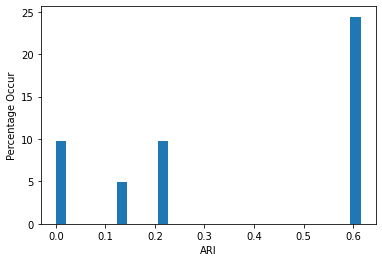

In [32]:
%matplotlib inline
totARI = np.transpose(totARI)
plt.hist(totARI, density=True, bins=30)
plt.ylabel('Percentage Occur')
plt.xlabel('ARI');

Cross tabulate the number of mushroom in each of the classes and in each of the clusters.

In [33]:
data_origin['cluster'] = bestAssignment
ct = pd.crosstab(data_origin['class'],data_origin['cluster'])
print(ct)

cluster     0     1
class              
e          60  4148
p        3100   816


In [34]:
err = (ct[0][1]+ct[1][0])/dataLen
print('% of mushrooms in wrong clusters:');print(err)
print('% of mushrooms in right clusters:');print(1-err)

% of mushrooms in wrong clusters:
0.8921713441654358
% of mushrooms in right clusters:
0.10782865583456425


## Conclusion

The result of each k-mean clustering operation is highly depended on the randomly selected initial centroids. Performing clustering for multiple times can help finding a good set of clusters. The best set of clusters found in this problem groups 89% of data correctly.